In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import copy

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

In [4]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_102516\3933838254.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_102516\3933838254.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [5]:
torch.manual_seed(99)
np.random.seed(99)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert pandas DataFrames to NumPy arrays, then to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
y_train_tensor = torch.FloatTensor(y_train.values if isinstance(y_train, pd.Series) else y_train)
X_val_tensor = torch.FloatTensor(X_val.values if isinstance(X_val, pd.DataFrame) else X_val)
y_val_tensor = torch.FloatTensor(y_val.values if isinstance(y_val, pd.Series) else y_val)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

# Get input dimensions
n_features = X_train.shape[1]

Using device: cuda:0


In [6]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(BinaryClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer - NO sigmoid here because we'll use BCEWithLogitsLoss
        self.feature_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)
    
    def forward(self, x):
        features = self.feature_layers(x)
        # Return raw logits - BCEWithLogitsLoss will handle the sigmoid internally
        return self.output_layer(features)

In [7]:
# Define training function
# Modify train_model function to return all losses for each epoch
def train_model_with_history(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, patience=5):
    model = model.to(device)
    
    # To track the best model
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    # Lists to store losses for plotting
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # Fix dimension issue - don't double unsqueeze the labels
            loss = criterion(outputs, labels.float().view(-1, 1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                # Fix dimension issue here too (in validation loop)
                loss = criterion(outputs, labels.float().view(-1, 1))
                
                val_loss += loss.item() * inputs.size(0)
        
        # Calculate average validation loss
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses
# Define prediction function
def predict(model, data_loader):
    model.eval()
    predictions = []
    
    model.to(device)
    
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            
            # Get raw logits
            logits = model(inputs)
            
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)
            
            predictions.append(probs.cpu().numpy())
    
    return np.vstack(predictions)

In [8]:
# Define custom ROC curve plotting function
def plot_PyTorch_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='r',
            label=f'PyTorch NN (AUC = {roc_auc:.3f})',
            lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [ ]:
def train_final_model(X_train, y_train, best_params):
    # Convert DataFrames to numpy arrays if needed
    if hasattr(X_train, 'values'):
        X_train = X_train.values
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    
    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=best_params['batch_size'], 
        shuffle=True
    )
    
    # Create model with best parameters
    model = BinaryClassifier(
        input_dim=X_train.shape[1],
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate']
    )
    
    # Setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    # Training
    model.to(device)
    model.train()
    
    # Training loop
    n_epochs = 150  # You can adjust this
    best_loss = float('inf')
    best_model_state = model.state_dict().copy()
    patience = 10
    epochs_no_improve = 0
    
    print("Training final model on entire dataset...")
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        
        # Print progress
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")
        
        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    print(f"Training complete. Final loss: {best_loss:.6f}")
    
    return model

# Best configuration from cross-validation
best_params = {
    'hidden_dims': [128, 64, 32],
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'batch_size': 64,
    'weight_decay': 0.0001
}

# Train final model on entire training set
final_model = train_final_model(X_train, y_train, best_params)

# Save the trained model
torch.save(final_model.state_dict(), 'best_model.pt')
print("Model saved to 'best_model.pt'")

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import pandas as pd
from tqdm.notebook import tqdm

# Binary Classifier Neural Network
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(BinaryClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        self.feature_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)
    
    def forward(self, x):
        features = self.feature_layers(x)
        return self.output_layer(features)

# Try fewer hyperparameter combinations
def quick_cv_search(X, y):
    # Convert DataFrames to numpy arrays if needed
    if hasattr(X, 'values'):
        X = X.values
    if hasattr(y, 'values'):
        y = y.values
    
    hidden_dims_options = [
         [64], [128], [256],
         [64, 32], [128, 64], [256, 128],
    ]  # Keeping all 10 options
    
    dropout_options = [0.6, 0.7]  # 3 options instead of 5
    
    lr_options = [0.001, 0.005]  # 2 options instead of 4
    
    batch_size_options = [64, 128]  # 2 options instead of 3
    
    weight_decay_options = [0.0001, 0.001]  # 2 options instead of 3
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    best_config = None
    best_auroc = 0
    results = []
    
    total_configs = len(hidden_dims_options) * len(dropout_options) * len(lr_options) * len(batch_size_options) * len(weight_decay_options)
    print(f"Running 10-fold CV for {total_configs} configurations")
    
    # Simplified version - using fixed batch size and weight decay to test the approach
    # Remove this section and uncomment the full search when ready
    config_count = 0
    for hidden_dims in hidden_dims_options:
        for dropout in dropout_options:
            for lr in lr_options:
                for batch_size in batch_size_options:
                    for weight_decay in weight_decay_options:
                        config_count += 1
                        print(f"Config {config_count}/{total_configs}: hidden={hidden_dims}, dropout={dropout}, lr={lr}, batch={batch_size}, wd={weight_decay}")
                        fold_scores = []
                        
                        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                            # Create data loaders
                            train_loader = DataLoader(
                                TensorDataset(X_tensor, y_tensor),
                                batch_size=batch_size,
                                sampler=SubsetRandomSampler(train_idx)
                            )
                            val_loader = DataLoader(
                                TensorDataset(X_tensor, y_tensor),
                                batch_size=batch_size,
                                sampler=SubsetRandomSampler(val_idx)
                            )
                            
                            # Create and train model
                            model = BinaryClassifier(X.shape[1], hidden_dims, dropout)
                            criterion = nn.BCEWithLogitsLoss()
                            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            
                            # Train the model with a fixed initial state
                            model = train_model(model, train_loader, val_loader, criterion, optimizer, device)
                            
                            # Evaluate model
                            model.eval()
                            all_preds = []
                            all_labels = []
                            
                            with torch.no_grad():
                                for inputs, labels in val_loader:
                                    inputs, labels = inputs.to(device), labels.to(device)
                                    outputs = model(inputs)
                                    probs = torch.sigmoid(outputs)
                                    all_preds.extend(probs.cpu().numpy().flatten())
                                    all_labels.extend(labels.cpu().numpy().flatten())
                            
                            auroc = roc_auc_score(all_labels, all_preds)
                            fold_scores.append(auroc)
                            print(f"  Fold {fold+1}/10: AUROC = {auroc:.4f}")
                        
                        # Calculate mean performance
                        mean_auroc = np.mean(fold_scores)
                        std_auroc = np.std(fold_scores)
                        print(f"  Mean AUROC: {mean_auroc:.4f} ± {std_auroc:.4f}")
                        
                        results.append({
                            'hidden_dims': hidden_dims,
                            'dropout': dropout,
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'weight_decay': weight_decay,
                            'mean_auroc': mean_auroc,
                            'std_auroc': std_auroc
                        })
                        
                        if mean_auroc > best_auroc:
                            best_auroc = mean_auroc
                            best_config = {
                                'hidden_dims': hidden_dims,
                                'dropout_rate': dropout,
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'weight_decay': weight_decay,
                                'mean_auroc': mean_auroc
                            }
    
    results_df = pd.DataFrame(results).sort_values('mean_auroc', ascending=False)
    
    print("\nTop 5 Hyperparameter Configurations:")
    print(results_df.head(5))
    
    print("\nBest Configuration:")
    print(f"Hidden Dimensions: {best_config['hidden_dims']}")
    print(f"Dropout Rate: {best_config['dropout_rate']}")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Weight Decay: {best_config['weight_decay']}")
    print(f"Mean AUROC: {best_config['mean_auroc']:.4f}")
    
    return best_config, results_df

# Simplified training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=30, patience=5):
    model = model.to(device)
    
    # Save initial state
    best_val_loss = float('inf')
    best_model_state = model.state_dict().copy()  # Initialize with starting state
    epochs_no_improve = 0
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
        
        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model

# Run a quick search
best_config, results = quick_cv_search(X_train, y_train)

Using device: cuda:0
Running 10-fold CV for 96 configurations
Config 1/96: hidden=[64], dropout=0.6, lr=0.001, batch=64, wd=0.0001
  Fold 1/10: AUROC = 0.8250
  Fold 2/10: AUROC = 0.8572
  Fold 3/10: AUROC = 0.8958
  Fold 4/10: AUROC = 0.9474
  Fold 5/10: AUROC = 0.9044
  Fold 6/10: AUROC = 0.9020
  Fold 7/10: AUROC = 0.9072
  Fold 8/10: AUROC = 0.9486
  Fold 9/10: AUROC = 0.7384
  Fold 10/10: AUROC = 0.8480
  Mean AUROC: 0.8774 ± 0.0599
Config 2/96: hidden=[64], dropout=0.6, lr=0.001, batch=64, wd=0.001
  Fold 1/10: AUROC = 0.7823
  Fold 2/10: AUROC = 0.8605
  Fold 3/10: AUROC = 0.8558
  Fold 4/10: AUROC = 0.9356
  Fold 5/10: AUROC = 0.8875
  Fold 6/10: AUROC = 0.8834
  Fold 7/10: AUROC = 0.8984
  Fold 8/10: AUROC = 0.9602
  Fold 9/10: AUROC = 0.7395
  Fold 10/10: AUROC = 0.8333
  Mean AUROC: 0.8636 ± 0.0630
Config 3/96: hidden=[64], dropout=0.6, lr=0.001, batch=128, wd=0.0001
  Fold 1/10: AUROC = 0.7556
  Fold 2/10: AUROC = 0.8558
  Fold 3/10: AUROC = 0.7980
  Fold 4/10: AUROC = 0.93

In [14]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [15]:
def train_final_model(X_train, y_train, best_params):
    # Convert DataFrames to numpy arrays if needed
    if hasattr(X_train, 'values'):
        X_train = X_train.values
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    
    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=best_params['batch_size'], 
        shuffle=True
    )
    
    # Create model with best parameters
    model = BinaryClassifier(
        input_dim=X_train.shape[1],
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate']
    )
    
    # Setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    # Training
    model.to(device)
    model.train()
    
    # Training loop
    n_epochs = 150  # You can adjust this
    best_loss = float('inf')
    best_model_state = model.state_dict().copy()
    patience = 10
    epochs_no_improve = 0
    
    print("Training final model on entire dataset...")
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        
        # Print progress
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")
        
        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    print(f"Training complete. Final loss: {best_loss:.6f}")
    
    return model

# Best configuration from cross-validation
best_params = {
    'hidden_dims': [64, 32],
    'dropout_rate': 0.6,
    'learning_rate': 0.005,
    'batch_size': 64,
    'weight_decay': 0.0001
}

# Train final model on entire training set
final_model = train_final_model(X_train, y_train, best_params)

# Save the trained model
torch.save(final_model.state_dict(), 'best_model.pt')
print("Model saved to 'best_model.pt'")

Using device: cuda:0
Training final model on entire dataset...
Epoch 5/150, Loss: 0.167280
Epoch 10/150, Loss: 0.145126
Epoch 15/150, Loss: 0.135004
Epoch 20/150, Loss: 0.134149
Epoch 25/150, Loss: 0.119101
Epoch 30/150, Loss: 0.112662
Epoch 35/150, Loss: 0.115448
Epoch 40/150, Loss: 0.108696
Epoch 45/150, Loss: 0.099834
Epoch 50/150, Loss: 0.105790
Epoch 55/150, Loss: 0.100268
Epoch 60/150, Loss: 0.094446
Epoch 65/150, Loss: 0.097423
Epoch 70/150, Loss: 0.090551
Epoch 75/150, Loss: 0.093081
Epoch 80/150, Loss: 0.083452
Early stopping triggered after epoch 83
Training complete. Final loss: 0.080857
Model saved to 'best_model.pt'


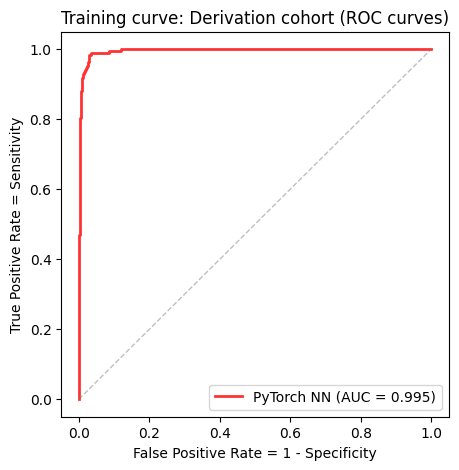

Training AUROC: 0.995 (95% CI: 0.993, 0.997)


In [16]:
# Predict on training data with the neural network
def predict_proba_nn(model, X):
    # Convert to numpy if DataFrame
    if hasattr(X, 'values'):
        X = X.values
        
    # Convert to tensor
    device = next(model.parameters()).device
    X_tensor = torch.FloatTensor(X).to(device)
    
    # Create dataloader
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=64)
    
    # Make predictions
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            predictions.extend(probs)
    
    # Convert to the same format as GBM output (two columns: [1-p, p])
    probs_array = np.column_stack((1 - np.array(predictions), np.array(predictions)))
    return probs_array

# Predict on training data
pred_probas_train = predict_proba_nn(final_model, X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_PyTorch_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")
print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


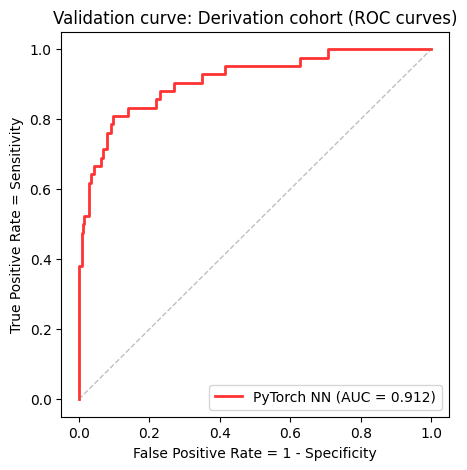

Val AUROC: 0.912 (95% CI: 0.858, 0.958)


In [17]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = predict_proba_nn(final_model, X_test)

# Compute ROC curve and area under the curve for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_probas_val[:,1])
roc_auc_test = auc(fpr_test, tpr_test)
plot_PyTorch_ROC_curve(fpr_test, tpr_test, roc_auc_test, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_val[:,1], "auroc")
print(f"Val AUROC: {roc_auc_test:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")